# Capstone Project Notebook

##### "In this assignment, you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto. However, unlike New York, the neighborhood data is not readily available on the internet. What is interesting about the field of data science is that each project can be challenging in its unique way, so you need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project.

##### For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the New York dataset.

##### Once the data is in a structured format, you can replicate the analysis that we did to the New York City dataset to explore and cluster the neighborhoods in the city of Toronto."

In [1]:
# import preliminary libraries etc
import numpy as np 
import pandas as pd
import json
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


### Leg 1: Segmenting and Clustering Neighborhoods
#### Obtain data from Wikipedia website

In [3]:
# Ended up not using Beautiful soup

#!pip install BeautifulSoup4
#!pip install requests
#from bs4 import BeautifulSoup
#import requests
#from urllib.request import urlopen
#!pip install lxml

In [ ]:
# install to read from wiki
!pip install wikipedia

In [4]:
import wikipedia as wp

In [5]:
# Obtain the page information
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df_tor = pd.read_html(html)[0]

#Delete rows where borough is not assigned
df_tor = df_tor[df_tor['Borough'] != 'Not assigned']

# change column names
column_names = ['PostalCode','Borough', 'Neighborhood'] 
df_tor.columns = column_names
df_tor.head(2)

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village


In [6]:
#Combine all neighborhoods where postcode and borough are the same
df_tor = df_tor.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()

# reset the index
df_tor.reset_index()

# view the table, viewing more rows shows distinct postal codes
df_tor.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
# inspect size of dataset
df_tor.shape

(103, 3)

### Leg 2: Adding coordinates to dataset 

In [15]:
import io
import requests

# add in longitude and latitude of postal codes
url="https://cocl.us/Geospatial_data"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

# join location parameters to original dataset
df_torl = df_tor.join(c.set_index('Postal Code'), on='PostalCode')
df_torl.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [10]:
from geopy.geocoders import Nominatim

In [11]:
address = 'Toronto'
# initialize variables to create folium map
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Leg 3: Mapping and Clustering 

In [13]:
import folium

In [87]:
# create map of New York using latitude and longitude values
map_tor = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_torl['Latitude'], df_torl['Longitude'], df_torl['Borough'], df_torl['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
# show toronto map overlayed with neighborhoods
map_tor

In [23]:
# map does not show when uploaded to github, so here is a picture of the above result: 

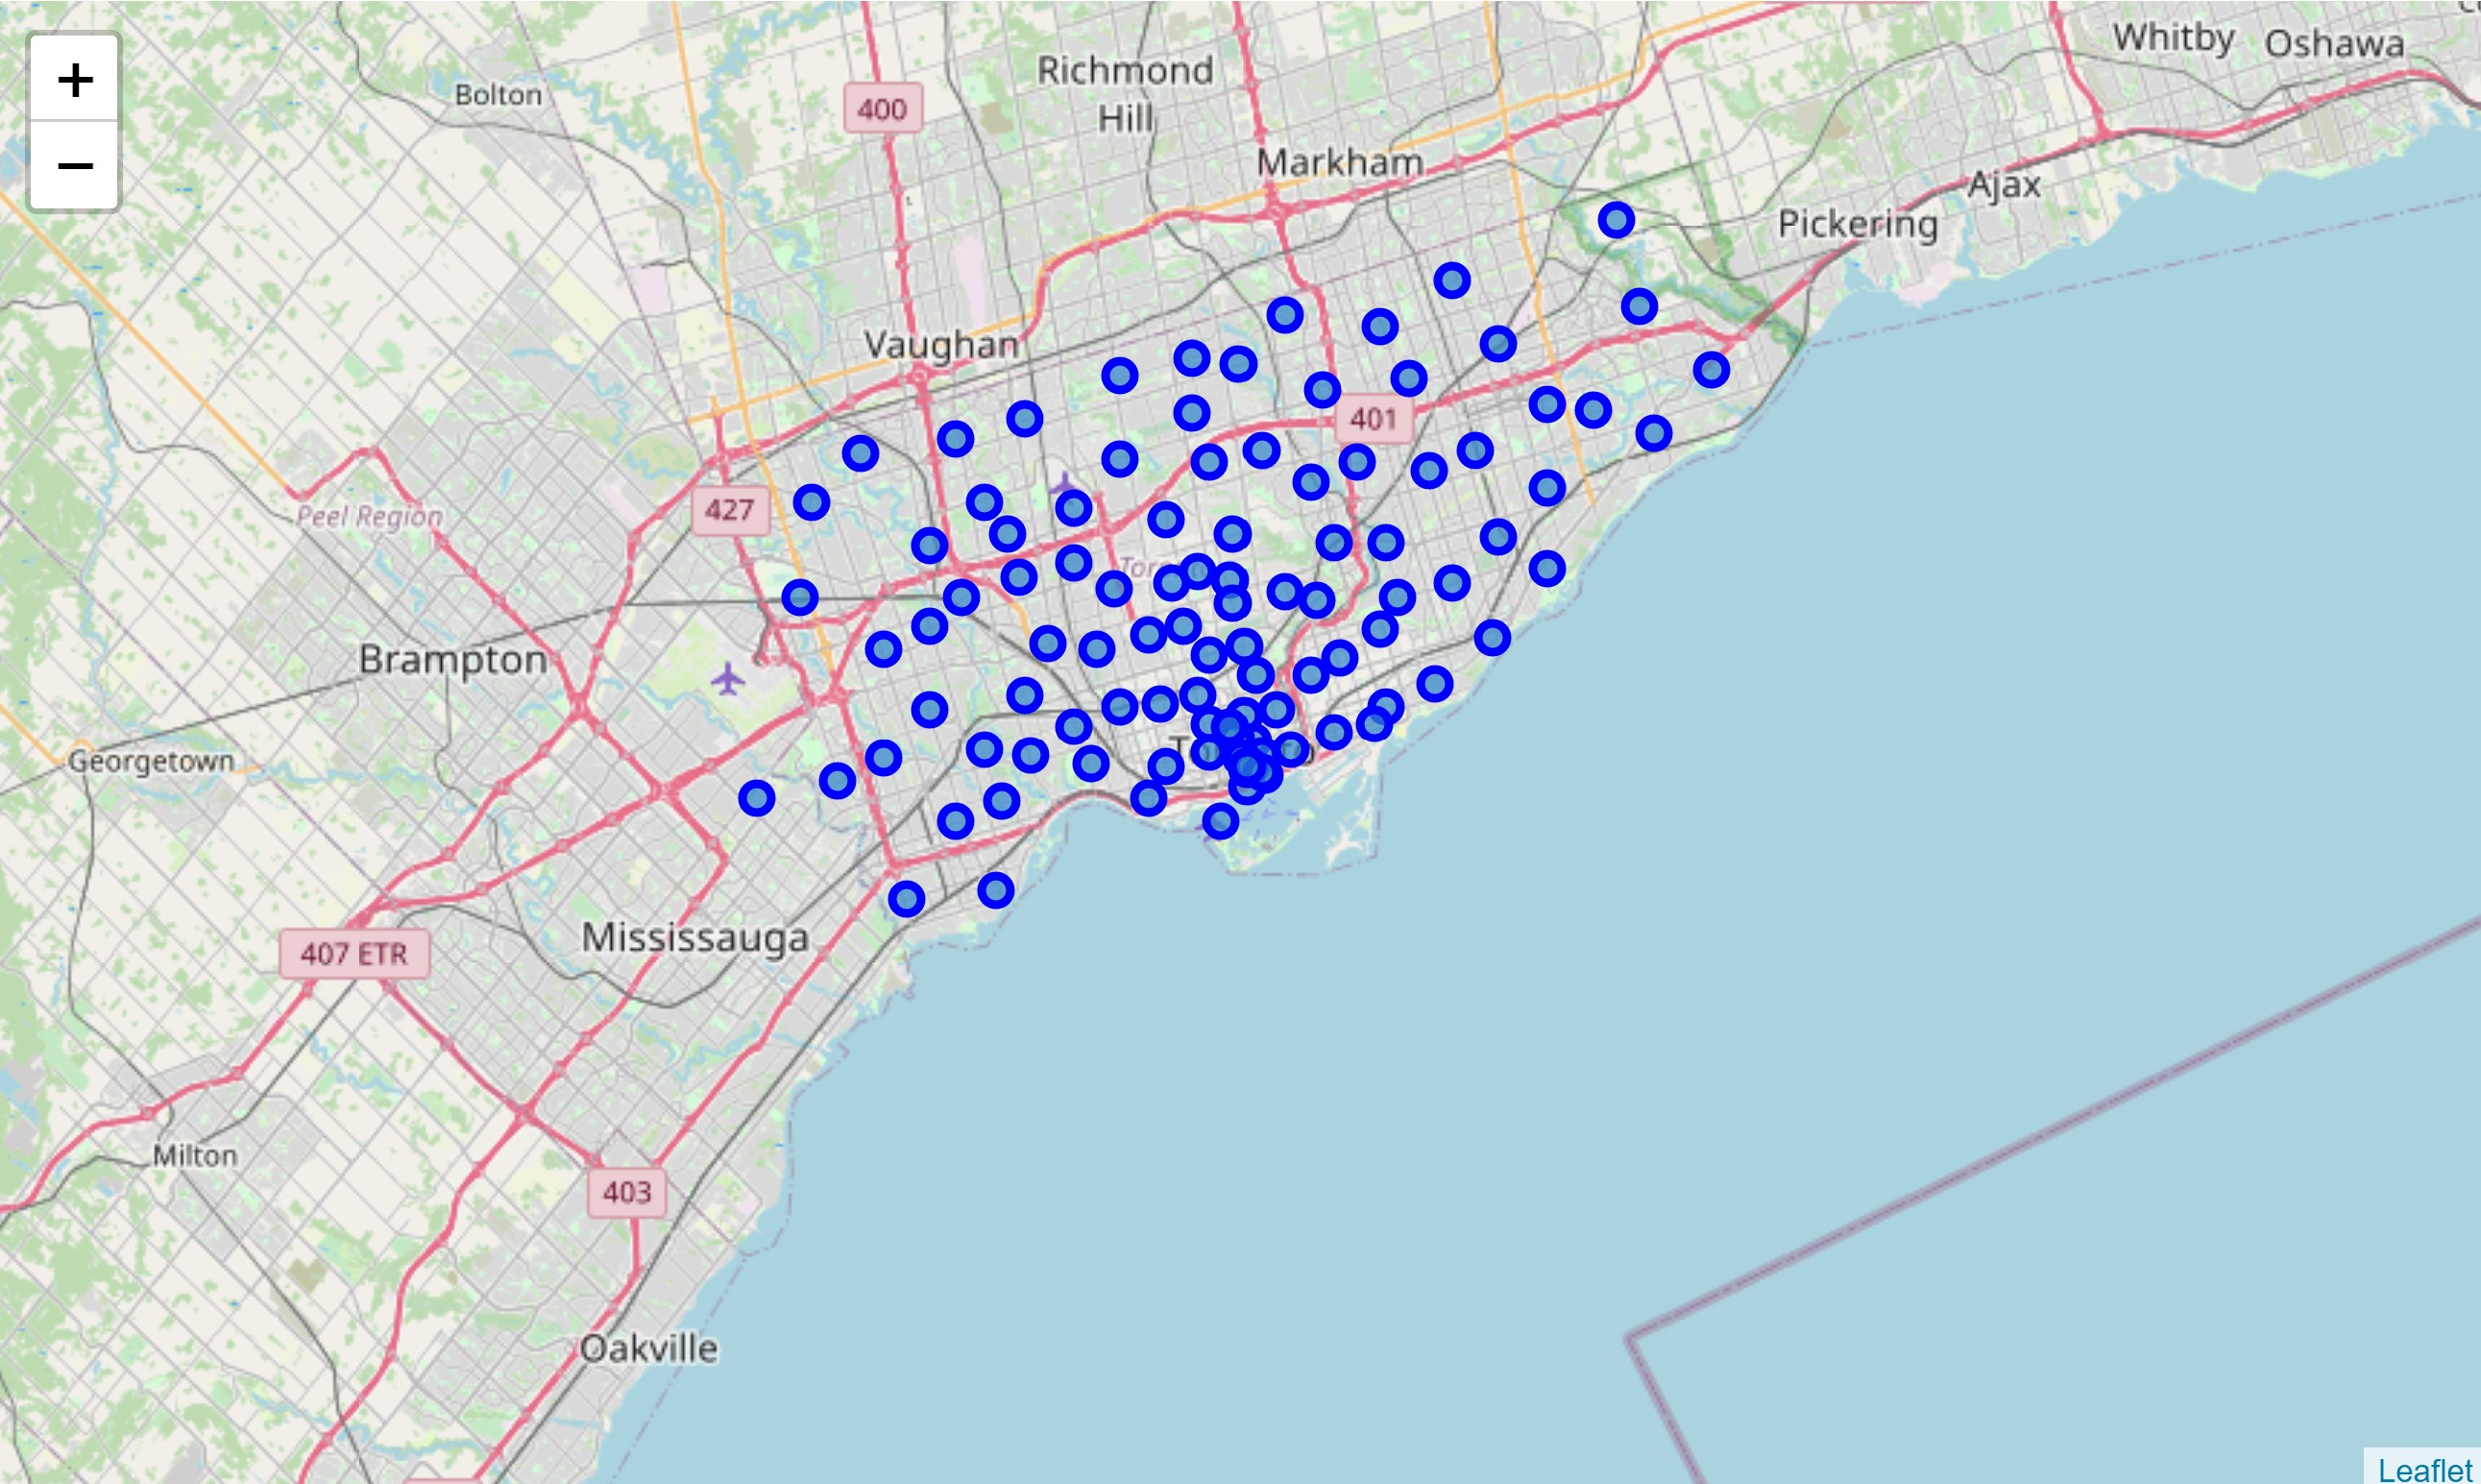

In [22]:
from IPython.display import Image
Image("map_tor.jpg")

In [25]:
# API information
LIMIT = 100

CLIENT_ID = 'TEH5ULXANVFVXKVOT5ZUU1EUIXUCXF2BPQLUIIN33IK0JXDP' 
CLIENT_SECRET = 'TL4GM2GSEC0BLRZAIVP40BMUHZ54KENBWK31OOBOGBIGZERQ' 
VERSION = '20180605' 

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: TEH5ULXANVFVXKVOT5ZUU1EUIXUCXF2BPQLUIIN33IK0JXDP
CLIENT_SECRET:TL4GM2GSEC0BLRZAIVP40BMUHZ54KENBWK31OOBOGBIGZERQ


In [26]:
# define function getNearbyVenues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
       
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
# Toronto venues using defined function
tor_venues = getNearbyVenues(names=df_torl['Neighborhood'],
                                   latitudes=df_torl['Latitude'],
                                   longitudes=df_torl['Longitude'],
                                  );

In [35]:
tor_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [36]:
tor_venues.shape

(2130, 7)

In [37]:
# Group by neighborhood
tor_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23


In [39]:
print('There are {} unique categories.'.format(len(tor_venues['Venue Category'].unique())))

There are 272 unique categories.


In [40]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tor_onehot['Neighborhood'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
tor_onehot.shape

(2130, 272)

In [45]:
tor_grouped = tor_onehot.groupby('Neighborhood').mean().reset_index()
tor_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,York Mills West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
tor_grouped.shape

(95, 272)

In [50]:
# see top 5 venues in an area
num_top_venues = 5

for hood in tor_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = tor_grouped[tor_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [51]:
# define function
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
# show top 10 venues and place in a dataframe
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tor_grouped['Neighborhood']

for ind in np.arange(tor_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Clothing Store,Lounge,Breakfast Spot,Skating Rink,Colombian Restaurant,Comfort Food Restaurant,Eastern European Restaurant,Dumpling Restaurant,Drugstore
1,"Alderwood, Long Branch",Pizza Place,Skating Rink,Coffee Shop,Gym,Pub,Pool,Sandwich Place,Dim Sum Restaurant,Dance Studio,Deli / Bodega
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Sushi Restaurant,Mobile Phone Shop,Pharmacy,Pizza Place,Middle Eastern Restaurant,Deli / Bodega,Restaurant,Bridal Shop
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Women's Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Restaurant,Grocery Store,Pharmacy,Juice Bar,Liquor Store,Indian Restaurant,Pub


#### Clustering

In [62]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [63]:
# set number of clusters
kclusters = 5

tor_grouped_clustering = tor_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [68]:
# add clustering labels

tor_merged = df_torl

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

tor_merged = tor_merged.dropna()


tor_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4.0,Fast Food Restaurant,Women's Store,Distribution Center,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.0,Bar,Women's Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Ethiopian Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Electronics Store,Rental Car Location,Breakfast Spot,Intersection,Bank,Medical Center,Mexican Restaurant,Concert Hall,Dessert Shop,Drugstore
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean Restaurant,Distribution Center,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Fried Chicken Joint,Caribbean Restaurant,Bakery,Athletics & Sports,Bank,Thai Restaurant,Gas Station,Hakka Restaurant,Dog Run,Distribution Center


In [70]:
# import needed libraries
import matplotlib.cm as cm
import matplotlib.colors as colors

In [77]:
# create folium map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# specify characteristics of marks
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], tor_merged['Neighborhood'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters
# *** map may not show on github ***

##### Cluster 1

In [ ]:
# Assign labels to clusters
tor_merged.loc[tor_merged['Cluster Labels'] == 0, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

##### Cluster 2

In [ ]:
tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

##### Cluster 3

In [84]:
tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Etobicoke,2.0,Baseball Field,Distribution Center,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Women's Store,Ethiopian Restaurant
97,North York,2.0,Baseball Field,Distribution Center,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Women's Store,Ethiopian Restaurant


##### Cluster 4

In [ ]:
tor_merged.loc[tor_merged['Cluster Labels'] == 3, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

##### Cluster 5

In [ ]:
tor_merged.loc[tor_merged['Cluster Labels'] == 4, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]